# Heart Disease Dataset Analysis
## CS14003 - Project 2: Decision Tree
# 
**Dataset**: UCI Heart Disease Dataset  
**Task**: Binary classification (Heart Disease: Yes/No)  
**Samples**: 303  
**Features**: 13 medical indicators

# Test

=== 📊 DỰ ÁN 2: DECISION TREE – CS14003 ===
📌 Dataset có 297 mẫu, 13 đặc trưng.
Phân phối nhãn:
condition
0    160
1    137
Name: count, dtype: int64


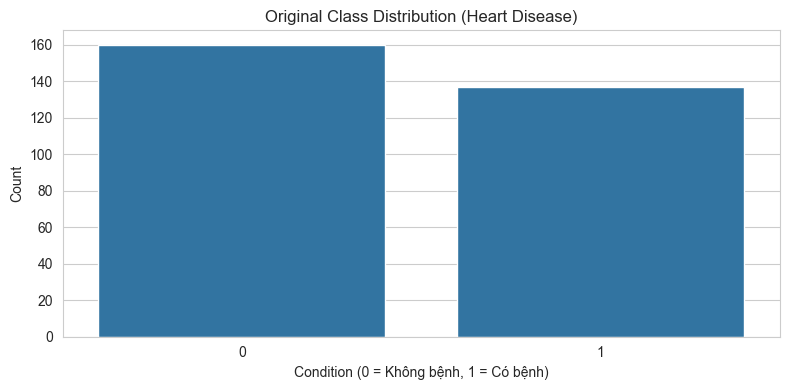

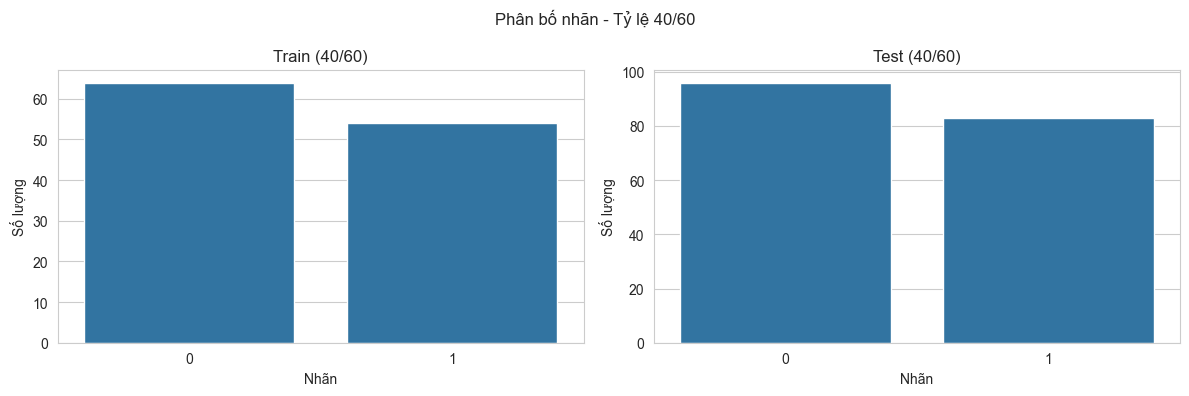

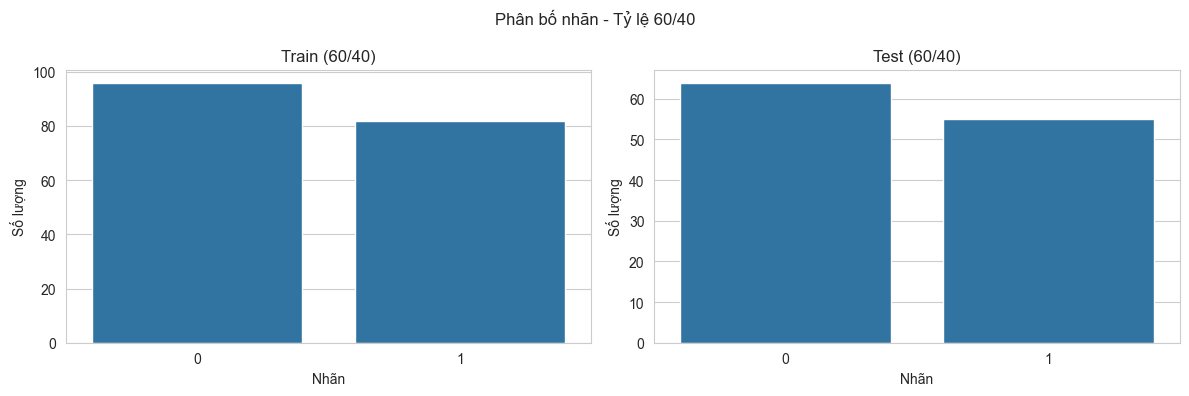

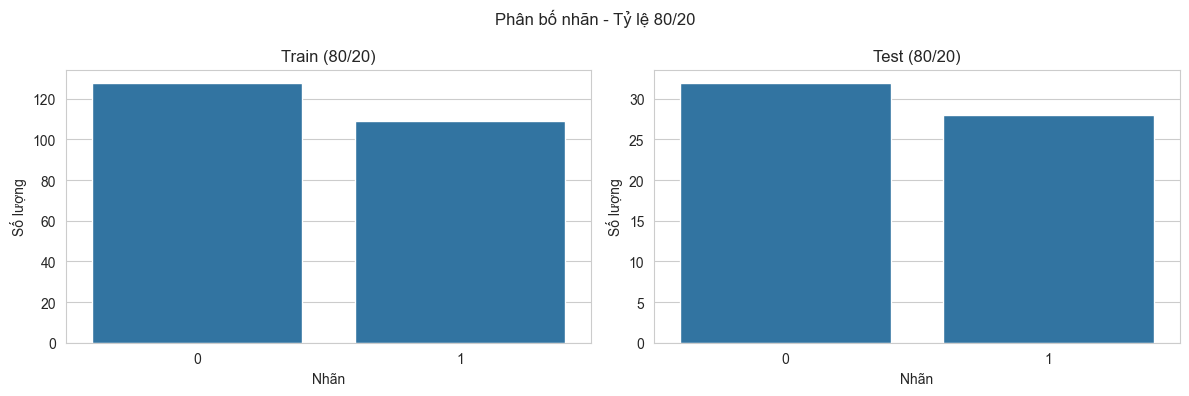

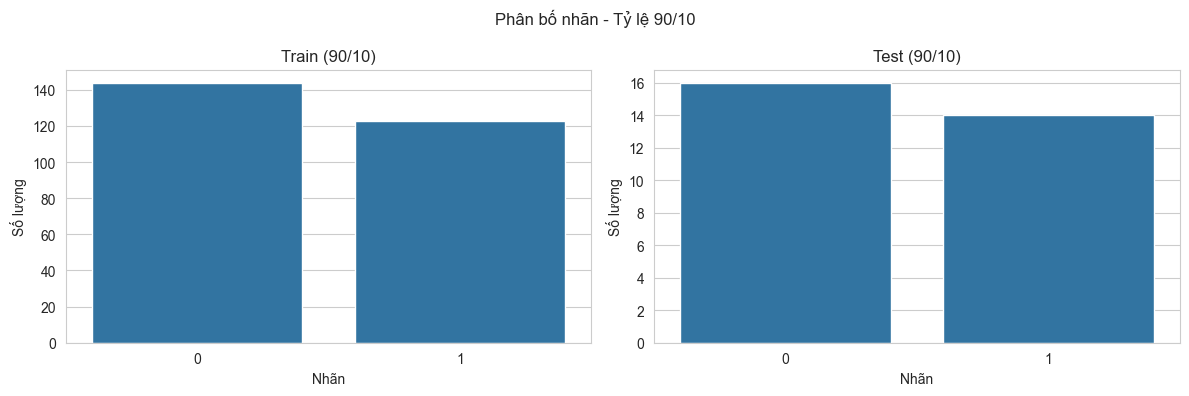

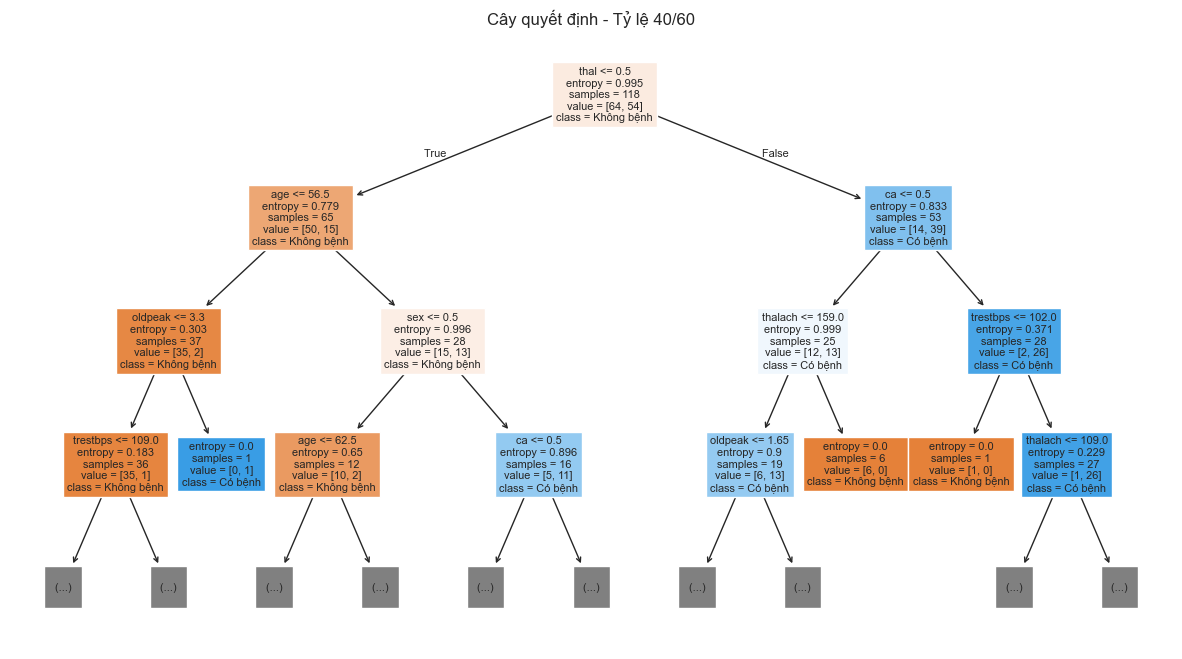

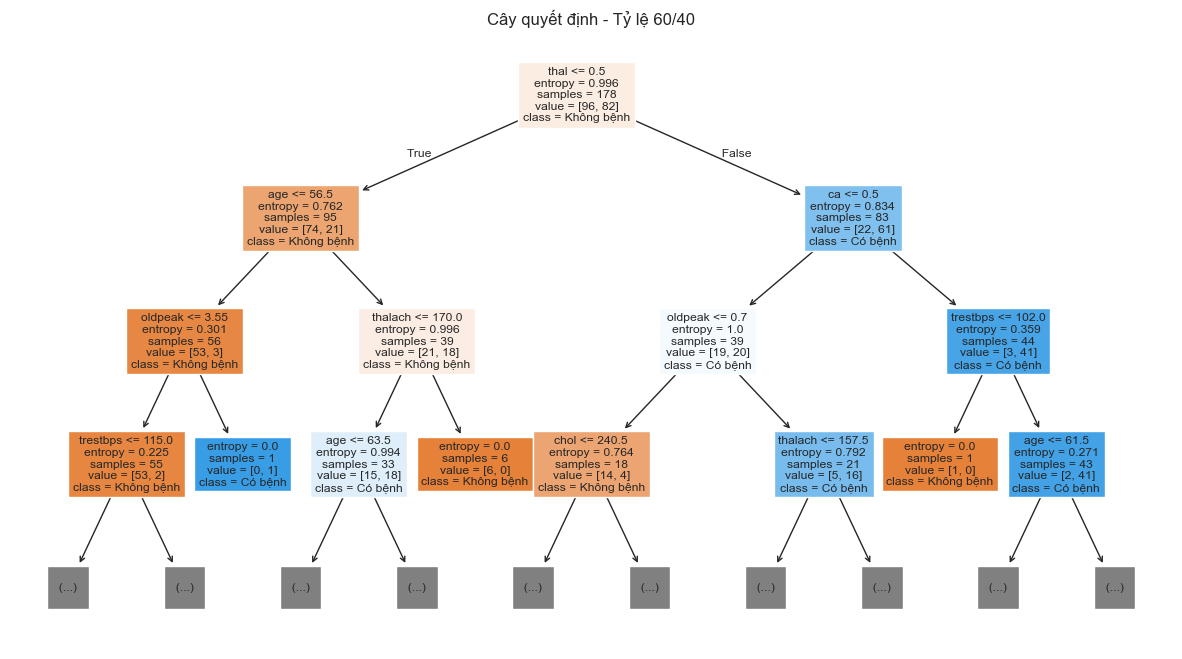

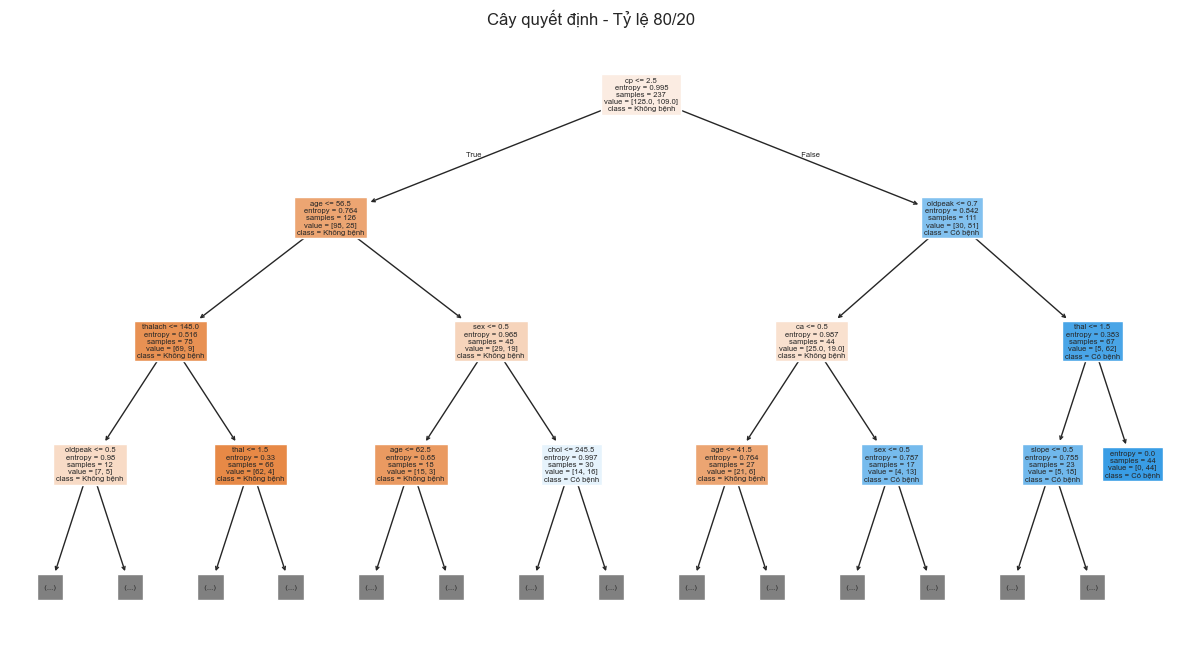

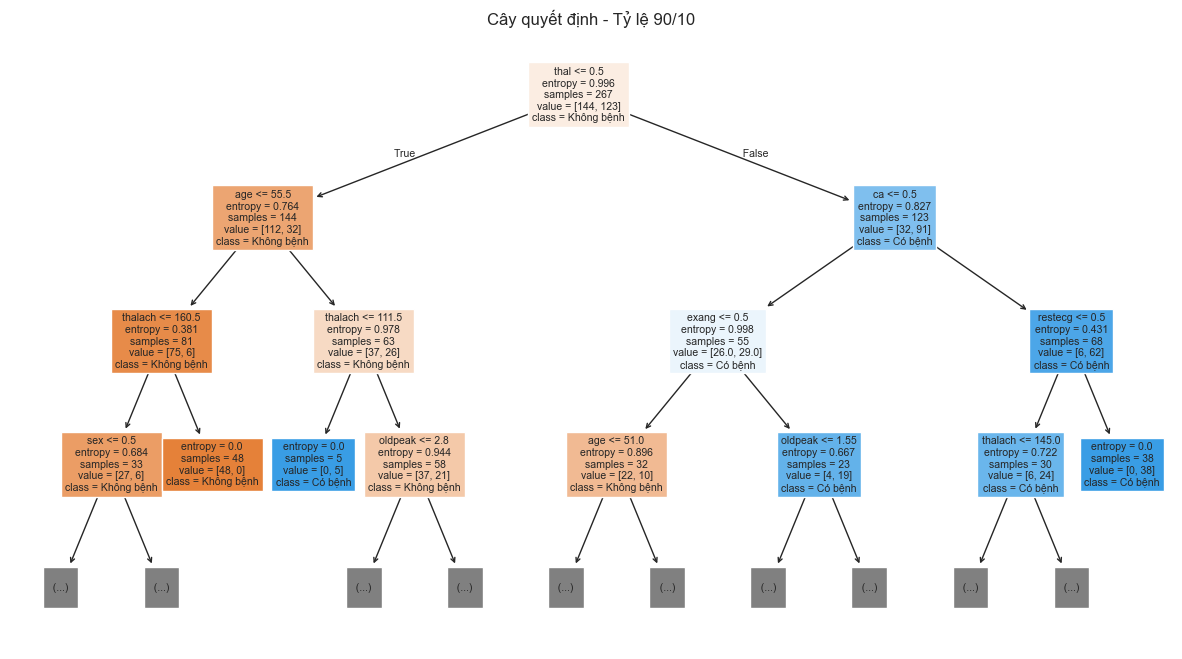


=== KẾT QUẢ TỶ LỆ 40/60 ===
              precision    recall  f1-score   support

  Không bệnh       0.78      0.80      0.79        96
     Có bệnh       0.76      0.73      0.75        83

    accuracy                           0.77       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.77      0.77      0.77       179



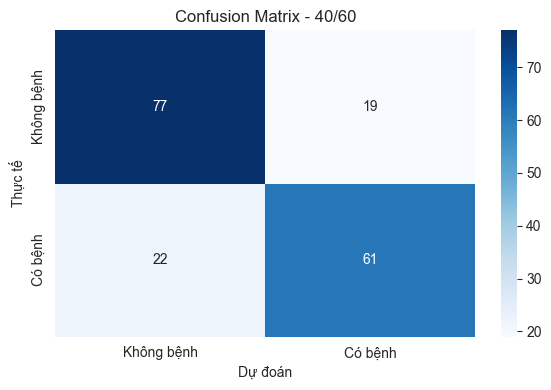


=== KẾT QUẢ TỶ LỆ 60/40 ===
              precision    recall  f1-score   support

  Không bệnh       0.70      0.72      0.71        64
     Có bệnh       0.66      0.64      0.65        55

    accuracy                           0.68       119
   macro avg       0.68      0.68      0.68       119
weighted avg       0.68      0.68      0.68       119



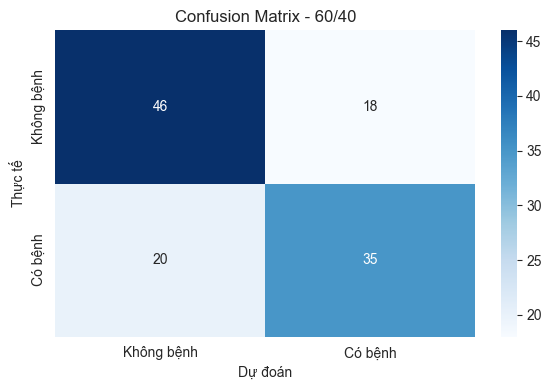


=== KẾT QUẢ TỶ LỆ 80/20 ===
              precision    recall  f1-score   support

  Không bệnh       0.89      0.75      0.81        32
     Có bệnh       0.76      0.89      0.82        28

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



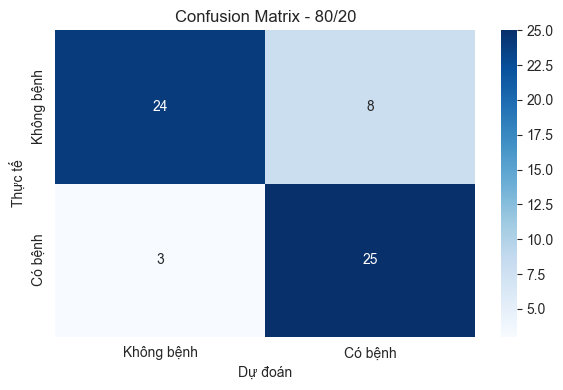


=== KẾT QUẢ TỶ LỆ 90/10 ===
              precision    recall  f1-score   support

  Không bệnh       0.67      0.75      0.71        16
     Có bệnh       0.67      0.57      0.62        14

    accuracy                           0.67        30
   macro avg       0.67      0.66      0.66        30
weighted avg       0.67      0.67      0.66        30



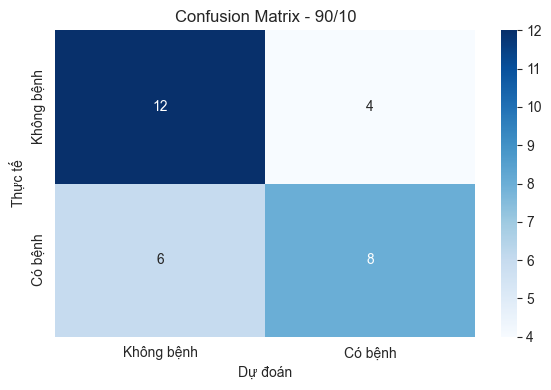

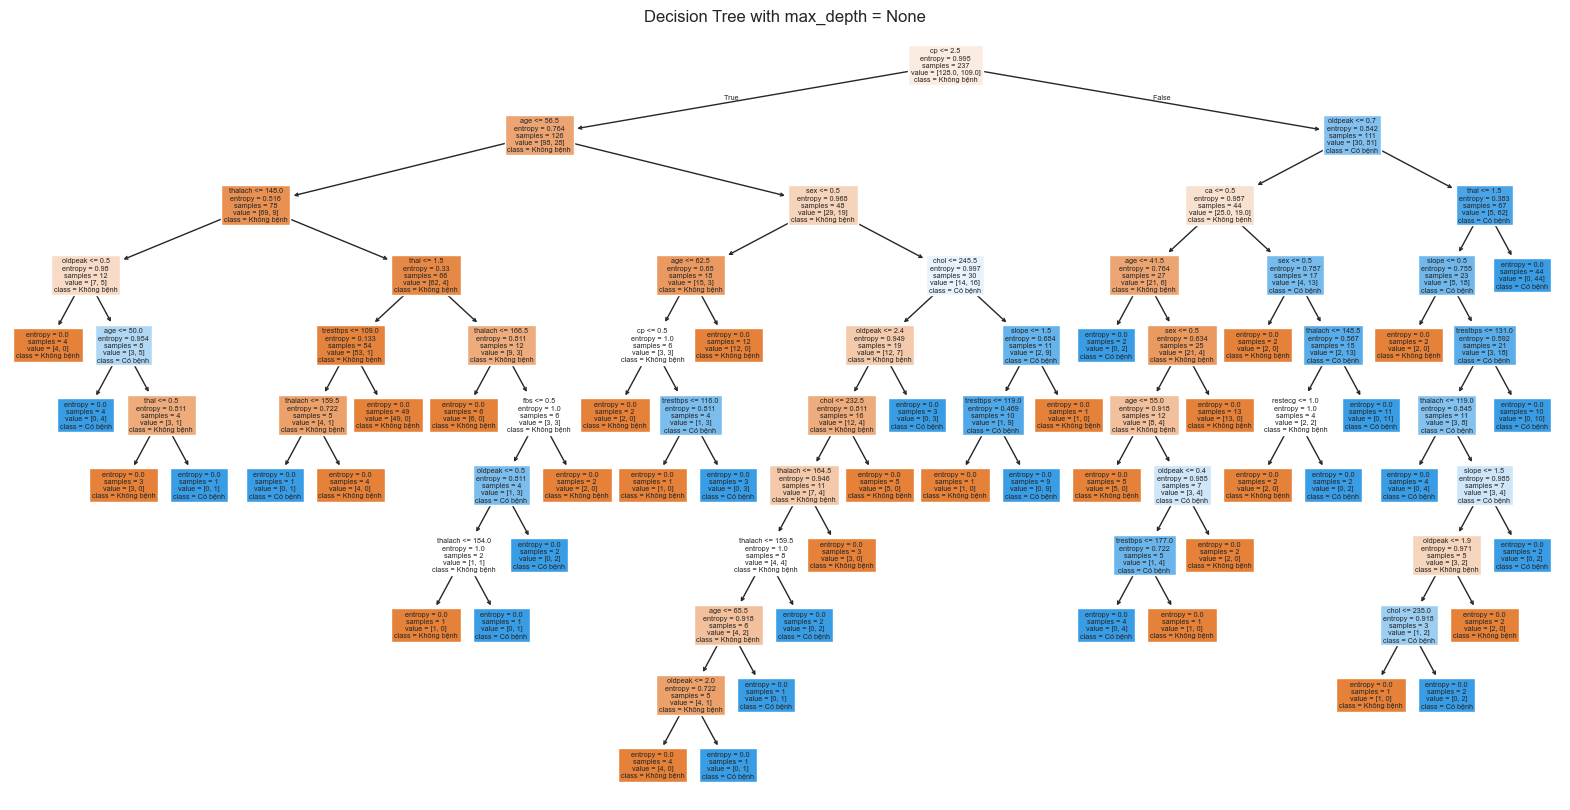

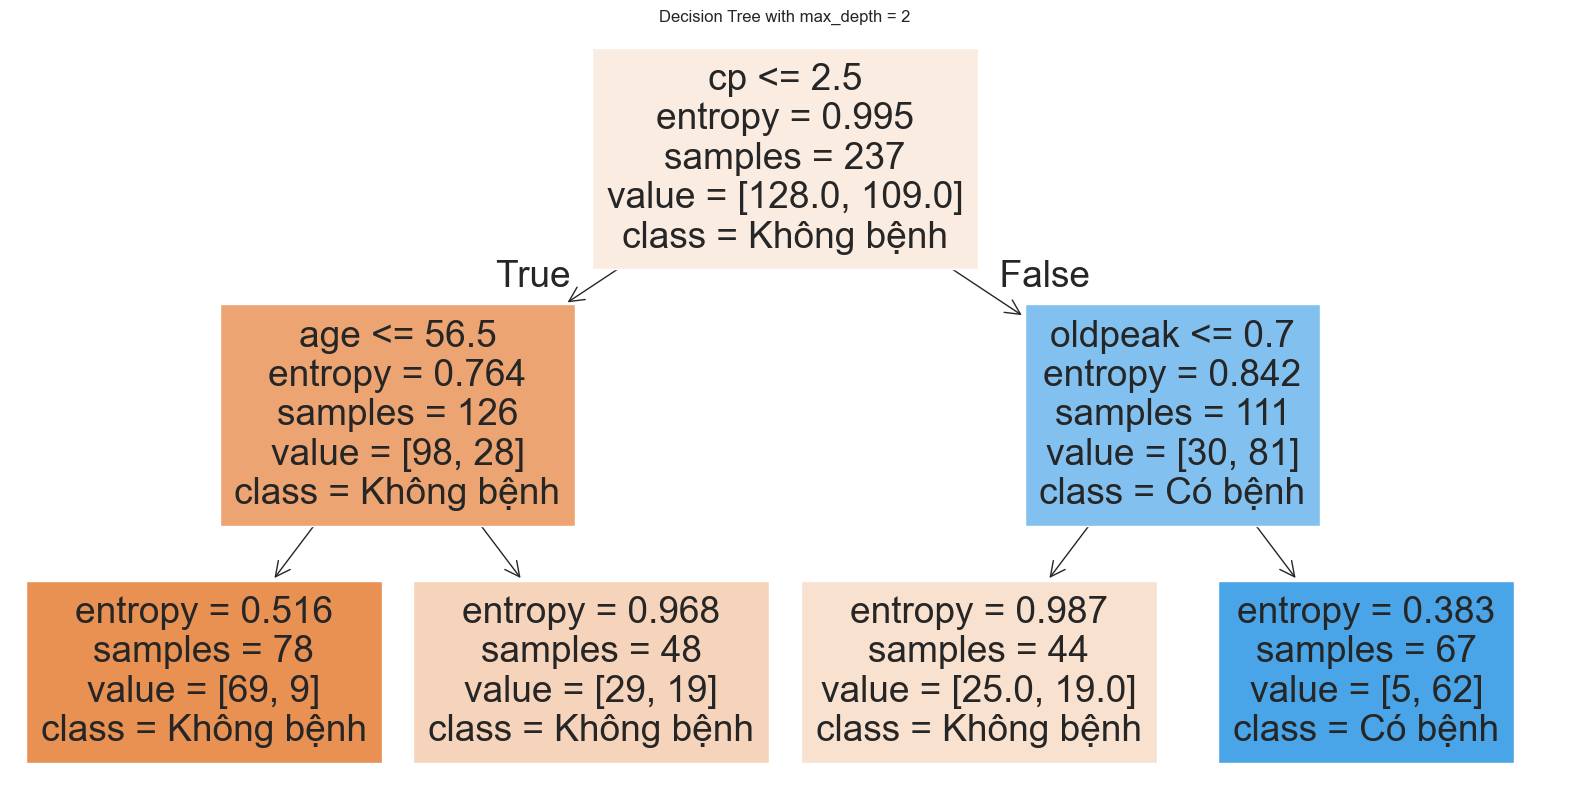

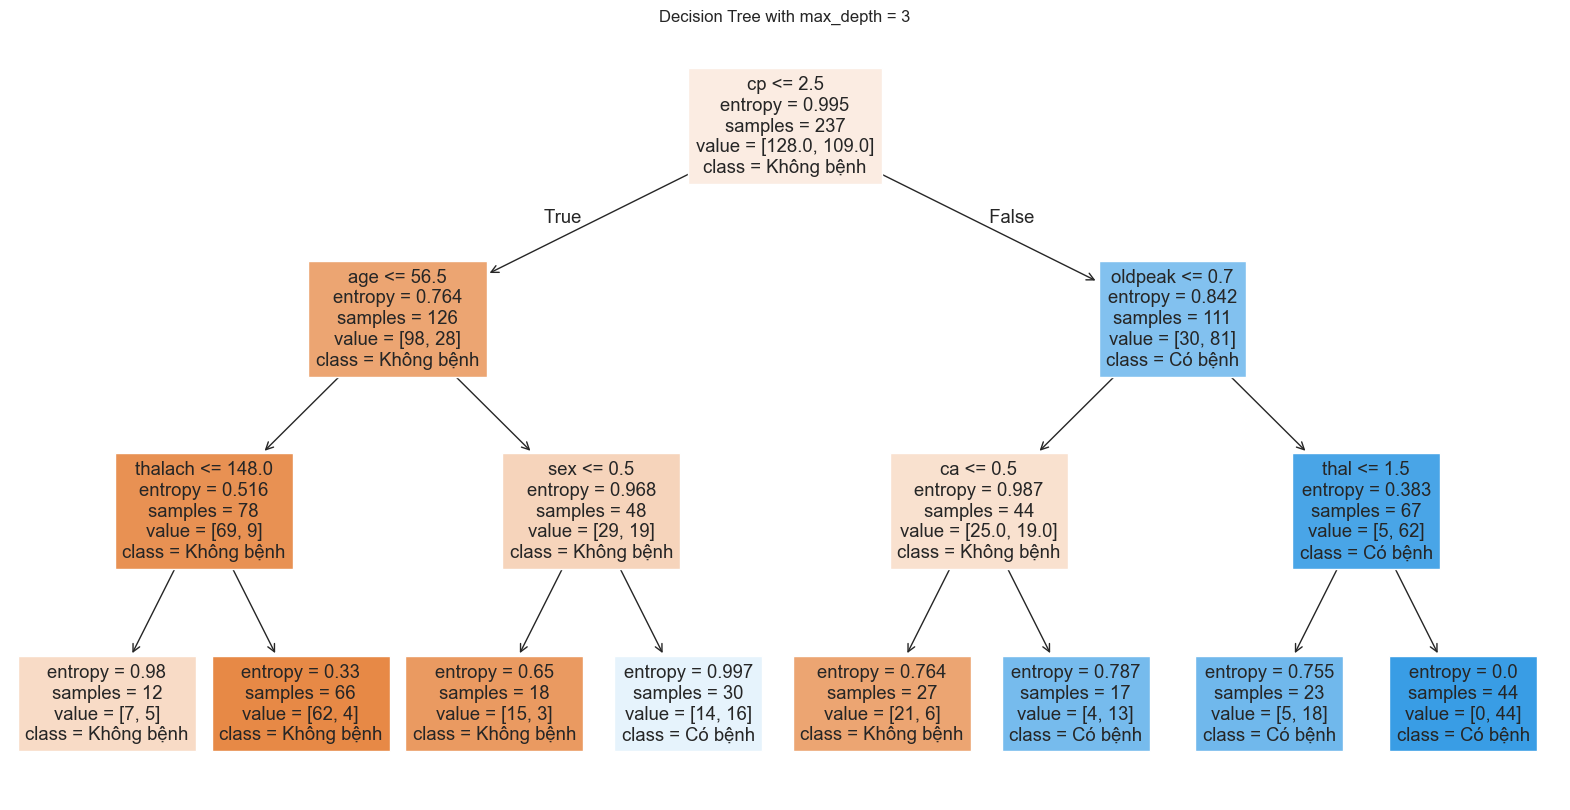

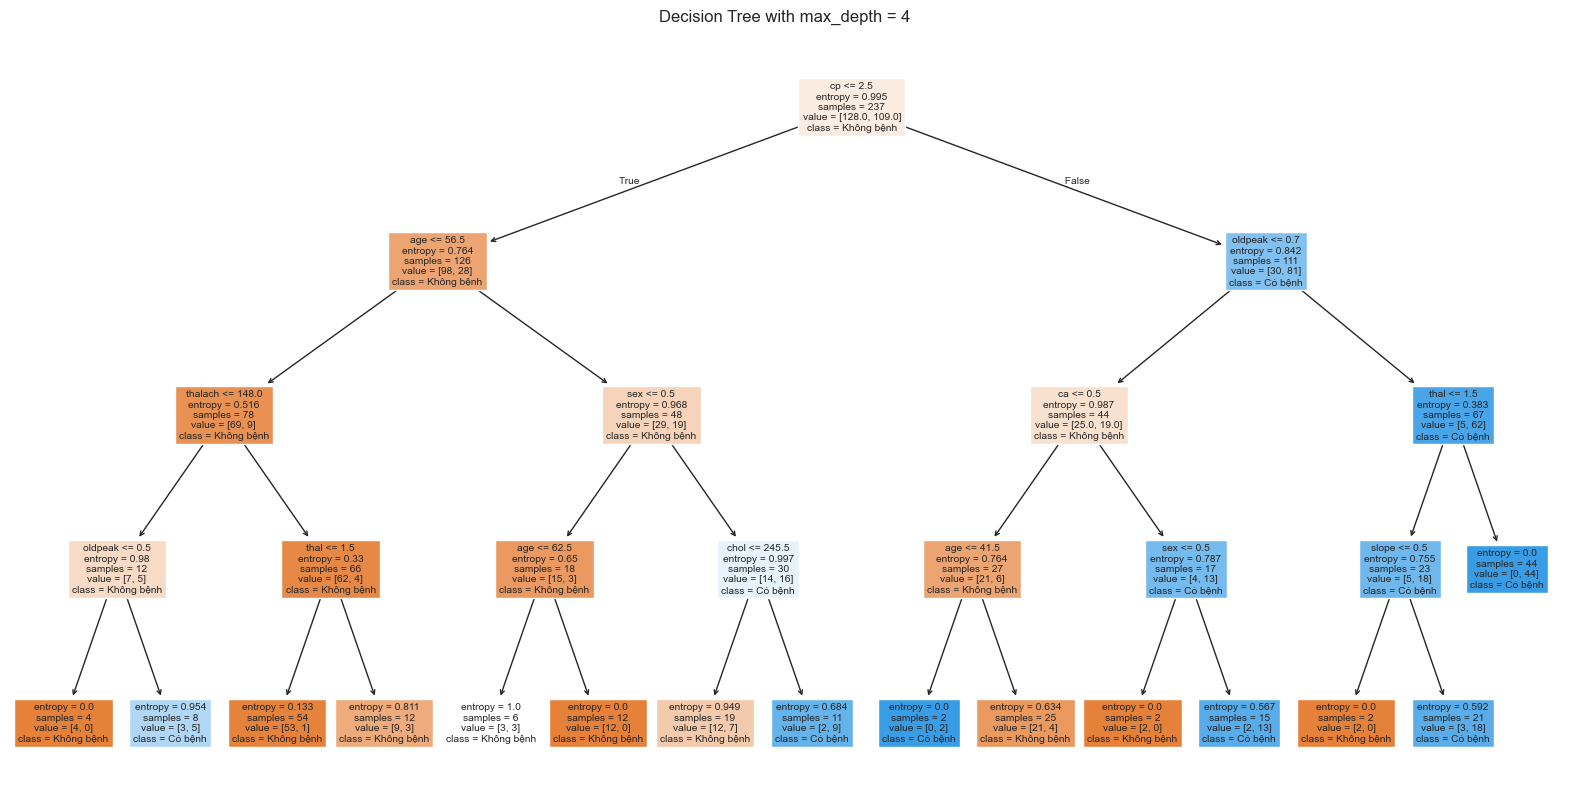

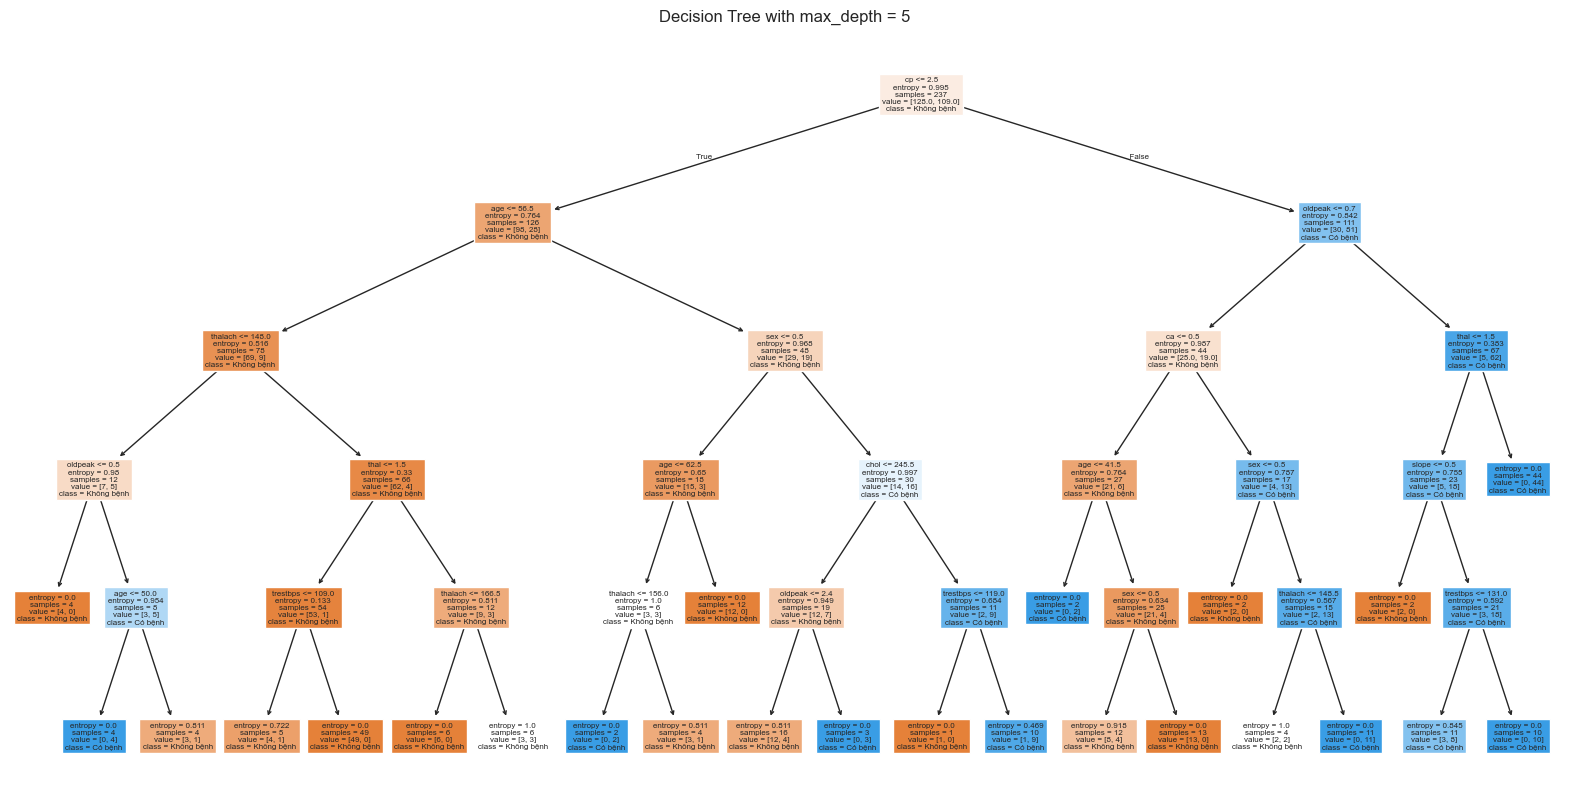

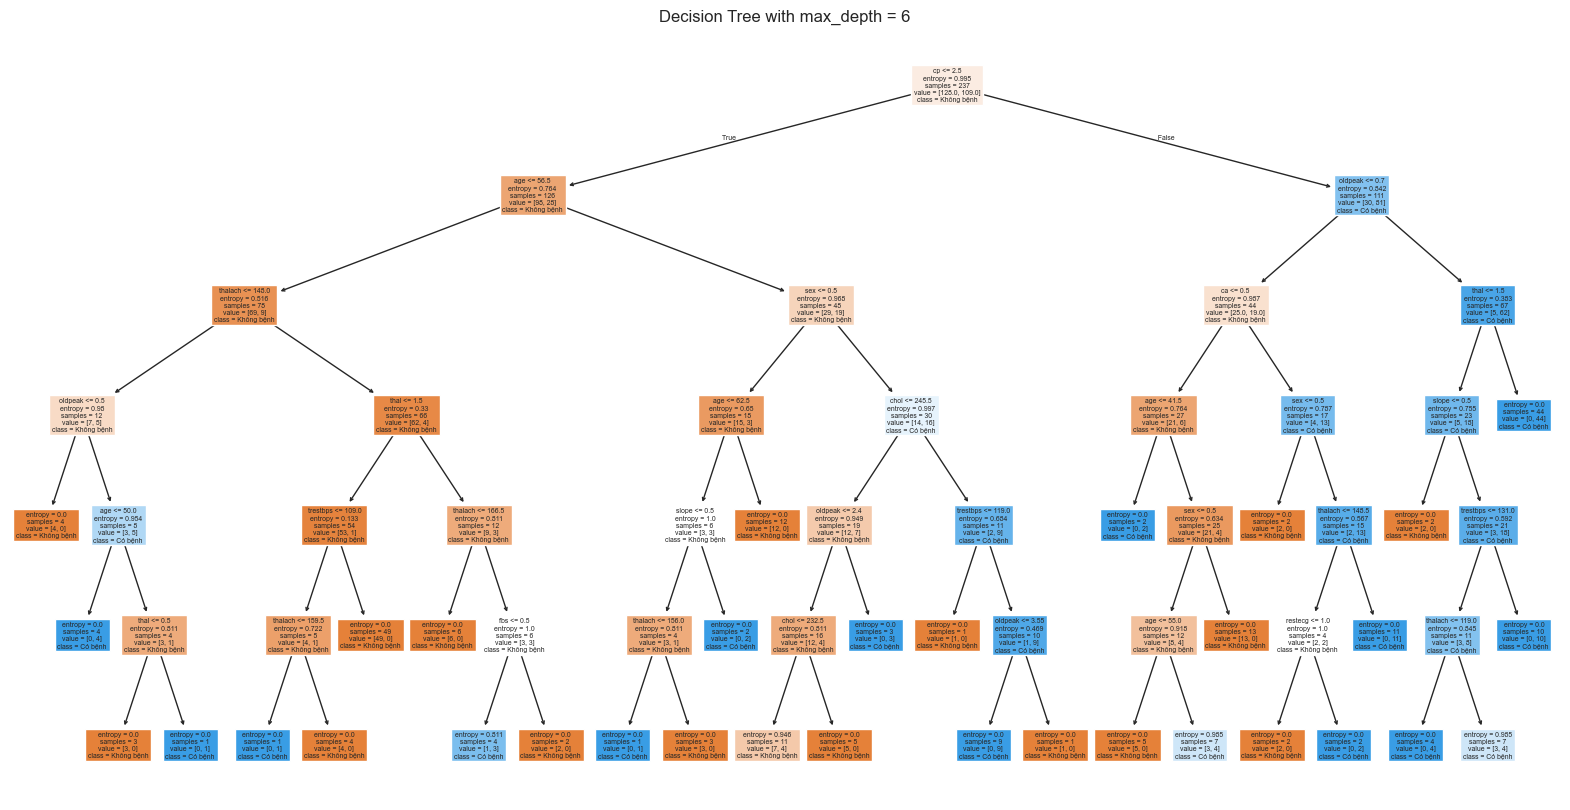

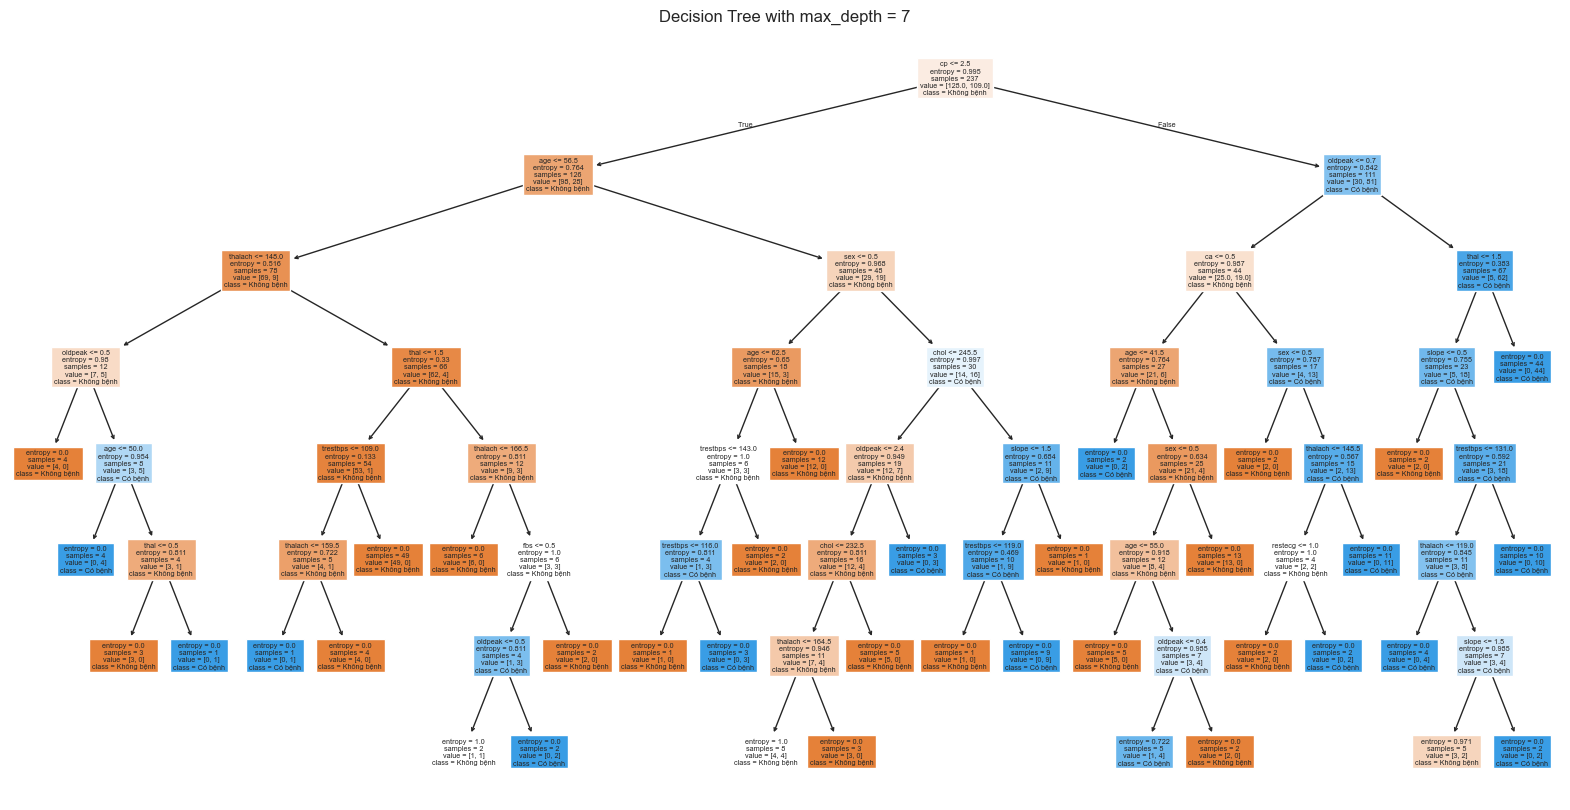


Depth vs Accuracy (80/20 split)
max_depth = None: accuracy = 0.8167
max_depth = 2: accuracy = 0.7000
max_depth = 3: accuracy = 0.8000
max_depth = 4: accuracy = 0.8333
max_depth = 5: accuracy = 0.8167
max_depth = 6: accuracy = 0.8333
max_depth = 7: accuracy = 0.8500


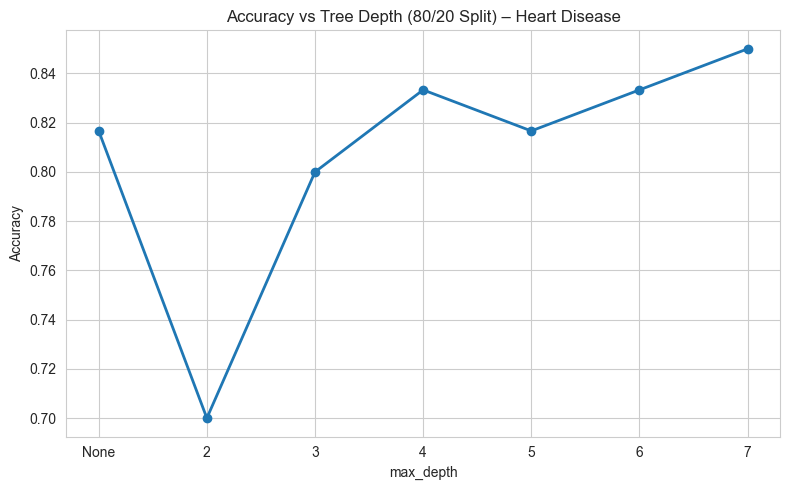


🔍 Max Accuracy (80/20 split): 0.8500


In [10]:
# 📘 Project 2: Decision Tree – Dataset: Heart Disease
# ✅ Câu 1: Huấn luyện và đánh giá mô hình trên tập Heart Disease

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("=== 📊 DỰ ÁN 2: DECISION TREE – CS14003 ===")

# ===== 1. ĐỌC DỮ LIỆU =====
df = pd.read_csv("../data/heart.csv")

# Tiền xử lý
if 'condition' not in df.columns:
    df.rename(columns={'target': 'condition'}, inplace=True)

df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)
df = df.astype(float)
df['condition'] = df['condition'].apply(lambda x: 0 if x == 0 else 1)

X = df.drop(columns=['condition'])
y = df['condition']

print(f"📌 Dataset có {X.shape[0]} mẫu, {X.shape[1]} đặc trưng.")
print("Phân phối nhãn:")
print(y.value_counts())

# 📊 Biểu đồ phân phối nhãn ban đầu
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Original Class Distribution (Heart Disease)")
plt.xlabel("Condition (0 = Không bệnh, 1 = Có bệnh)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ===== 2. CHIA TẬP DỮ LIỆU =====
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
heart_splits = {}

for train_size, test_size in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42)
    key = f"{int(train_size*100)}/{int(test_size*100)}"
    heart_splits[key] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

# Hàm vẽ phân bố nhãn
for ratio, data in heart_splits.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=data['y_train'], ax=axes[0])
    axes[0].set_title(f"Train ({ratio})")
    axes[0].set_xlabel("Nhãn")
    axes[0].set_ylabel("Số lượng")
    axes[0].grid(True, axis='y')

    sns.countplot(x=data['y_test'], ax=axes[1])
    axes[1].set_title(f"Test ({ratio})")
    axes[1].set_xlabel("Nhãn")
    axes[1].set_ylabel("Số lượng")
    axes[1].grid(True, axis='y')

    plt.suptitle(f"Phân bố nhãn - Tỷ lệ {ratio}")
    plt.tight_layout()
    plt.show()

# ===== 3. HUẤN LUYỆN MÔ HÌNH =====
heart_models = {}
for ratio, data in heart_splits.items():
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(data['X_train'], data['y_train'])
    heart_models[ratio] = clf

    # Hiển thị cây quyết định (giới hạn độ sâu 3 cho dễ quan sát)
    plt.figure(figsize=(15, 8))
    plot_tree(clf, feature_names=X.columns, class_names=["Không bệnh", "Có bệnh"], filled=True, max_depth=3)
    plt.title(f"Cây quyết định - Tỷ lệ {ratio}")
    plt.show()

# ===== 4. ĐÁNH GIÁ MÔ HÌNH =====
for ratio, data in heart_splits.items():
    clf = heart_models[ratio]
    y_pred = clf.predict(data['X_test'])

    print(f"\n=== KẾT QUẢ TỶ LỆ {ratio} ===")
    print(classification_report(data['y_test'], y_pred, target_names=["Không bệnh", "Có bệnh"]))

    cm = confusion_matrix(data['y_test'], y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Không bệnh", "Có bệnh"], yticklabels=["Không bệnh", "Có bệnh"])
    plt.title(f"Confusion Matrix - {ratio}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.tight_layout()
    plt.show()

# ===== 5. PHÂN TÍCH max_depth TRÊN TẬP 80/20 =====
ratio_80_20 = heart_splits['80/20']
max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_acc = []

for d in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    clf.fit(ratio_80_20['X_train'], ratio_80_20['y_train'])
    y_pred = clf.predict(ratio_80_20['X_test'])
    acc = accuracy_score(ratio_80_20['y_test'], y_pred)
    depth_acc.append(acc)

    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=X.columns, class_names=["Không bệnh", "Có bệnh"], filled=True)
    plt.title(f"Decision Tree with max_depth = {d}")
    plt.show()
# In kết quả max accuracy cuối cùng và bảng
print("\nDepth vs Accuracy (80/20 split)")
for d, acc in zip(max_depths, depth_acc):
    print(f"max_depth = {d}: accuracy = {acc:.4f}")
# Biểu đồ ảnh hưởng độ sâu
plt.figure(figsize=(8, 5))
plt.plot(["None" if d is None else d for d in max_depths], depth_acc, marker='o', linewidth=2)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth (80/20 Split) – Heart Disease")
plt.grid(True)
plt.tight_layout()
plt.show()


max_acc = max(depth_acc)
print(f"\n🔍 Max Accuracy (80/20 split): {max_acc:.4f}")
